Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.cuda.amp import autocast, GradScaler

from torchvision.models import vgg19_bn, VGG19_BN_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torchvision.models import resnet18, ResNet18_Weights

from torchvision.transforms import Normalize, ToTensor, Compose
import torchvision.transforms as T

import os
from PIL import Image
import PIL
import albumentations as A
from albumentations.pytorch import ToTensorV2

import math
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
print(vgg19_bn())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [3]:
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=0)
else:
    device=torch.device(type="cpu", index=0)

In [4]:
device

device(type='cuda', index=0)

Image Type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Mask Type: <class 'PIL.GifImagePlugin.GifImageFile'>
Image Size: (565, 584)
Image Shape: (584, 565, 3) Mask Shape: (584, 565)
Unique in Mask: [  0 255]
Image Data Type: uint8
Mask Data Type: uint8


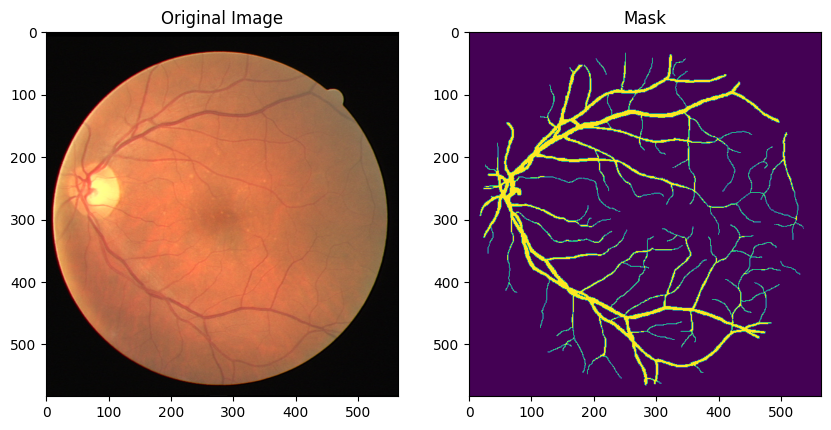

In [ ]:
img_path = '/kaggle/input/sai-vessel-segmentation2/all/train/21_training.tif'
mask_path = '/kaggle/input/sai-vessel-segmentation2/all/train/21_manual1.gif'
img = Image.open(img_path)
mask = Image.open(mask_path)

print("Image Type:", type(img))
print("Mask Type:", type(mask))
print("Image Size:", img.size)

img_array = np.array(img)
mask_array = np.array(mask)
print("Image Shape:", img_array.shape, "Mask Shape:", mask_array.shape)
print("Unique in Mask:", np.unique(mask_array))
print("Image Data Type:", img_array.dtype)
print("Mask Data Type:", mask_array.dtype)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_array)
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask_array)
plt.show()


In [6]:
def reshape_to_512(imgpath):
    ori_image = Image.open(imgpath)
    reshaped_image=ori_image.resize((512,512),PIL.Image.NEAREST)
      
    return reshaped_image

After Reshape:
Image Type: <class 'PIL.Image.Image'>
Mask Type: <class 'PIL.Image.Image'>
Image Shape: (512, 512, 3) Mask Shape: (512, 512) Image dtype: uint8 Mask dtype: uint8
Unique in Mask: [  0 255]
Number of Ones in Mask: 19531.0


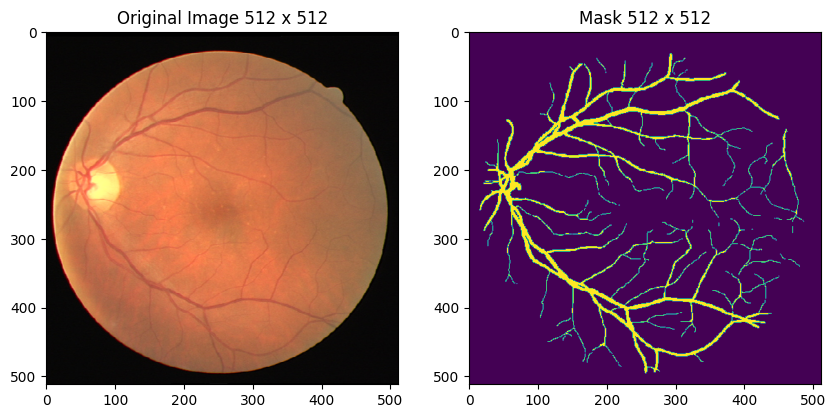

In [ ]:
img = reshape_to_512('/kaggle/input/sai-vessel-segmentation2/all/train/21_training.tif')
mask = reshape_to_512('/kaggle/input/sai-vessel-segmentation2/all/train/21_manual1.gif')

print("After Reshape:")
print("Image Type:", type(img))
print("Mask Type:", type(mask))
print("Image Shape:", np.array(img).shape, "Mask Shape:", np.array(mask).shape, "Image dtype:", np.array(img).dtype, "Mask dtype:", np.array(mask).dtype)
print("Unique in Mask:", np.unique(mask))
print("Number of Ones in Mask:", np.sum(np.sum(np.array(mask)/255)))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image 512 x 512")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title("Mask 512 x 512")
plt.imshow(mask)
plt.show()

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.path = path
        _, _, self.filepaths = next(os.walk(path))
        self.length = int(len(self.filepaths) / 2) - 4

        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ElasticTransform(p=0.2),
            A.GridDistortion(p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
            ToTensorV2()  
        ])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        idx = idx + 21
        img_path = self.path + str(idx) + "_training.tif"
        mask_path = self.path + str(idx) + "_manual1.gif"

        img = np.array(reshape_to_512(img_path))  
        mask = np.array(reshape_to_512(mask_path))  
        
        augmented = self.transform(image=img, mask=mask)  
        img = augmented["image"]
        mask = augmented["mask"]
    
        mask = mask.long()  
        mask[mask == 255] = 1  
    
        return img, mask


class ValDataset(Dataset):
    def __init__(self,path,transform=None):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=int(len(self.filepaths)/2)-16
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        idx=idx+37
        path=self.path + str(idx) + "_training.tif"
        img=reshape_to_512(path)
        img=self.transform(img)
        
        path=self.path + str(idx) + "_manual1.gif"
        mask=reshape_to_512(path)
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        mask[mask==255]=1
                      
        return img, mask

train_dataset = TrainDataset("/kaggle/input/sai-vessel-segmentation2/all/train/")

val_dataset = ValDataset("/kaggle/input/sai-vessel-segmentation2/all/train/")

In [9]:
batch_size=2

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Image dtype: torch.float32 Mask dtype: torch.int64
Unique in Mask: [0 1]


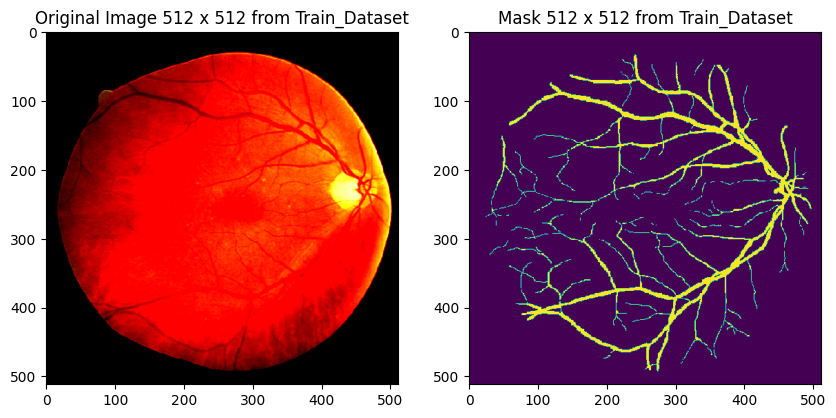

In [10]:
img,mask=train_dataset[0]

print("Image Shape:",img.shape,"Mask Shape:",mask.shape,"Image dtype:",img.dtype, "Mask dtype:", mask.dtype)
print("Unique in Mask:",np.unique(mask))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512 from Train_Dataset")
plt.imshow(torch.permute(img,(1,2,0)))

plt.subplot(1,2,2)
plt.title("Mask 512 x 512 from Train_Dataset")
plt.imshow(mask)
plt.show()

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        num_classes = logits.shape[1]
        
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)
        
        intersection = (probs * targets_one_hot).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()
    
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.4, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        reduction_channels = max(channels // reduction, 8)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, reduction_channels, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduction_channels, channels, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y

In [ ]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # VGG19 branch
        vgg19 = vgg19_bn(weights=VGG19_BN_Weights.DEFAULT)
        self.vgg_encoder = Encoder(vgg19)
        self.vgg_center = Center(512, 1024)
        self.vgg_decoder = Decoder(encoder_type='vgg')
        
        # ResNext branch
        resnext = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)
        self.resnext_encoder = ResNextEncoder(resnext)
        self.resnext_center = Center(512, 512)
        self.resnext_decoder = Decoder(encoder_type='resnet')
        
        # EfficientNet branch
        efficientnet = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
        self.efficient_encoder = EfficientNetEncoder(efficientnet)
        self.efficient_center = Center(512, 512)
        self.efficient_decoder = Decoder(encoder_type='efficient')
        
        # Enhanced fusion layer with attention for three models
        self.fusion_attention = SEBlock(6)  # Updated for 3 models (2 channels each)
        self.fusion = nn.Sequential(
            nn.Conv2d(6, 6, kernel_size=3, padding=1),
            nn.BatchNorm2d(6),
            nn.PReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(6, 2, kernel_size=1)
        )
        
        # Weighted fusion parameters
        self.fusion_weights = nn.Parameter(torch.ones(3) / 3)  # Initialize with equal weights
        self.fusion_temperature = nn.Parameter(torch.tensor(1.0))
    
    def forward(self, x):
        # VGG19 branch
        vgg_features = self.vgg_encoder(x)
        vgg_center = self.vgg_center(vgg_features[-1])
        vgg_output = self.vgg_decoder(vgg_center, vgg_features)
        
        # ResNext branch
        resnet_features = self.resnext_encoder(x)
        resnet_center = self.resnext_center(resnet_features[-1])
        resnet_output = self.resnext_decoder(resnet_center, resnet_features)
        
        # EfficientNet branch
        efficient_features = self.efficient_encoder(x)
        efficient_center = self.efficient_center(efficient_features[-1])
        efficient_output = self.efficient_decoder(efficient_center, efficient_features)
        
        fusion_weights = F.softmax(self.fusion_weights / self.fusion_temperature, dim=0)
        
        combined = torch.cat([
            vgg_output * fusion_weights[0],
            resnet_output * fusion_weights[1],
            efficient_output * fusion_weights[2]
        ], dim=1)
        
        combined = self.fusion_attention(combined)
        final_output = self.fusion(combined)
        return final_output, vgg_output, resnet_output, efficient_output

In [ ]:
class EfficientNetEncoder(nn.Module):
    def __init__(self, pretrained_network):
        super().__init__()
        
        self.stage1 = nn.Sequential(
            pretrained_network.features[0],  
            pretrained_network.features[1]   
        )
        
        self.stage2 = pretrained_network.features[2:4]
        self.stage3 = pretrained_network.features[4:6]
        self.stage4 = pretrained_network.features[6:8]
        self.stage5 = pretrained_network.features[8:]
        
        self.attention1 = SEBlock(24)    
        self.attention2 = SEBlock(56)    
        self.attention3 = SEBlock(160)
        self.attention4 = SEBlock(448)
        self.attention5 = SEBlock(1792)
        
        self.adapt1 = nn.Sequential(
            nn.Conv2d(24, 64, 1),
            nn.Dropout2d(0.1)
        )
        self.adapt2 = nn.Sequential(
            nn.Conv2d(56, 128, 1),   
            nn.Dropout2d(0.1)
        )
        self.adapt3 = nn.Sequential(
            nn.Conv2d(160, 256, 1),
            nn.Dropout2d(0.1)
        )
        self.adapt4 = nn.Sequential(
            nn.Conv2d(448, 512, 1),
            nn.Dropout2d(0.1)
        )
        self.adapt5 = nn.Sequential(
            nn.Conv2d(1792, 512, 1),
            nn.Dropout2d(0.1)
        )
    
    def forward(self, x):
        features = []
        
        x = self.stage1(x)
        x = self.attention1(x)
        features.append(self.adapt1(x))
        
        x = self.stage2(x)
        x = self.attention2(x)
        features.append(self.adapt2(x))
        
        x = self.stage3(x)
        x = self.attention3(x)
        features.append(self.adapt3(x))
        
        x = self.stage4(x)
        x = self.attention4(x)
        features.append(self.adapt4(x))
        
        x = self.stage5(x)
        x = self.attention5(x)
        features.append(self.adapt5(x))
        
        return features

In [15]:
class Encoder(nn.Module):
    def __init__(self,pretrained_network):
        super().__init__()
        self.encoder=pretrained_network
    
    def forward(self,x):
        encoder_features_outputs=[]
        for layer in self.encoder.features:
                x=layer(x)
                encoder_features_outputs.append(x)
                        
        return encoder_features_outputs

In [ ]:
class ResNextEncoder(nn.Module):
    def __init__(self, pretrained_network):
        super().__init__()
        self.stage1 = nn.Sequential(
            pretrained_network.conv1,      
            pretrained_network.bn1,
            pretrained_network.relu,
            pretrained_network.maxpool
        )
        self.stage2 = pretrained_network.layer1
        self.stage3 = pretrained_network.layer2
        self.stage4 = pretrained_network.layer3
        self.stage5 = pretrained_network.layer4
        
        self.attention1 = SEBlock(64)
        self.attention2 = SEBlock(256)
        self.attention3 = SEBlock(512)
        self.attention4 = SEBlock(1024)
        self.attention5 = SEBlock(2048)
        
        self.adapt1 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.Dropout2d(0.1)
        )
        self.adapt2 = nn.Sequential(
            nn.Conv2d(256, 128, 1),
            nn.Dropout2d(0.1)
        )
        self.adapt3 = nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.Dropout2d(0.1)
        )
        self.adapt4 = nn.Sequential(
            nn.Conv2d(1024, 512, 1),
            nn.Dropout2d(0.1)
        )
        self.adapt5 = nn.Sequential(
            nn.Conv2d(2048, 512, 1),
            nn.Dropout2d(0.1)
        )
        
    def forward(self, x):
        features = []
        
        x = self.stage1(x)
        x = self.attention1(x)
        features.append(self.adapt1(x))
        
        x = self.stage2(x)
        x = self.attention2(x)
        features.append(self.adapt2(x))
        
        x = self.stage3(x)
        x = self.attention3(x)
        features.append(self.adapt3(x))
        
        x = self.stage4(x)
        x = self.attention4(x)
        features.append(self.adapt4(x))
        
        x = self.stage5(x)
        x = self.attention5(x)
        features.append(self.adapt5(x))
        
        return features

In [17]:
class Center(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.PReLU()
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, encoder_type='vgg'):
        super().__init__()
        self.encoder_type = encoder_type
        self.rl = nn.PReLU()
        self.drop = nn.Dropout(0.15)
        self.drop1 = nn.Dropout(0.1)

        in_channels = 1024 if encoder_type == 'vgg' else 512
        
        self.conv5_up=nn.Conv2d(in_channels=in_channels, out_channels=512, kernel_size=3, padding=1)
        self.conv5_1=nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)
        self.bn5_1=nn.BatchNorm2d(num_features=512)
        self.conv5_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_2=nn.BatchNorm2d(num_features=512)
        self.conv5_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_3=nn.BatchNorm2d(num_features=512)
        self.conv5_4=nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1)
        self.bn5_4 = nn.BatchNorm2d(num_features=512)
        
        self.conv4_up=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.conv4_1=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.bn4_1=nn.BatchNorm2d(num_features=512)
        self.conv4_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_2=nn.BatchNorm2d(num_features=512)
        self.conv4_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_3=nn.BatchNorm2d(num_features=512)
        self.conv4_4=nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1)
        self.bn4_4 = nn.BatchNorm2d(num_features=512)
        
        self.conv3_up=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.conv3_1=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.bn3_1=nn.BatchNorm2d(num_features=256)
        self.conv3_2=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_2=nn.BatchNorm2d(num_features=256)
        self.conv3_3=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_3=nn.BatchNorm2d(num_features=256)
        self.conv3_4=nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        self.bn3_4 = nn.BatchNorm2d(num_features=256)
        
        self.conv2_up=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.conv2_1=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.bn2_1=nn.BatchNorm2d(num_features=128)
        self.conv2_2=nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3,padding=1)
        self.bn2_2=nn.BatchNorm2d(num_features=128)
        
        self.conv1_up=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.conv1_1=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.bn1_1=nn.BatchNorm2d(num_features=64)
        self.conv1_2=nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3,padding=1)
        self.bn1_2=nn.BatchNorm2d(num_features=64)
        
        self.convfinal=nn.Conv2d(in_channels=64,out_channels=2,kernel_size=1)

        if encoder_type == 'vgg':
            self.skip_idx = [51, 38, 25, 12, 5]
        else:
            self.skip_idx = [4, 3, 2, 1, 0]
    
    def forward(self,x, encoder_features_output):
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv5_up(x)
        x=self.rl(x)
        skip_feature = encoder_features_output[self.skip_idx[0]]
        if skip_feature.shape[2:] != x.shape[2:]:
            skip_feature = F.interpolate(skip_feature, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, skip_feature), dim=1)
        x=self.conv5_1(x)
        x=self.bn5_1(x)
        x=self.rl(x)
        x=self.conv5_2(x)
        x=self.bn5_2(x)
        x=self.rl(x)
#         x=self.drop(x)
        x=self.conv5_3(x)
        x=self.bn5_3(x)
        x=self.rl(x)
        x=self.drop1(x)
        x=self.conv5_4(x)
        x=self.bn5_4(x)
        x=self.rl(x)
        x = self.drop(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv4_up(x)
        x=self.rl(x)
        skip_feature = encoder_features_output[self.skip_idx[1]]  # Use skip_idx[1] instead of 38
        if skip_feature.shape[2:] != x.shape[2:]:
            skip_feature = F.interpolate(skip_feature, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, skip_feature), dim=1)
        x=self.conv4_1(x)
        x=self.bn4_1(x)
        x=self.rl(x)
        x=self.conv4_2(x)
        x=self.bn4_2(x)
        x=self.rl(x)
#         x=self.drop1(x)
        x=self.conv4_3(x)
        x=self.bn4_3(x)
        x=self.rl(x)
        x=self.drop1(x)
        x=self.conv4_4(x)
        x=self.bn4_4(x)
        x=self.rl(x)
        x = self.drop(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv3_up(x)
        x=self.rl(x)
        skip_feature = encoder_features_output[self.skip_idx[2]]  # Use skip_idx[2] instead of 25
        if skip_feature.shape[2:] != x.shape[2:]:
            skip_feature = F.interpolate(skip_feature, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, skip_feature), dim=1)
        x=self.conv3_1(x)
        x=self.bn3_1(x)
        x=self.rl(x)
        x=self.conv3_2(x)
        x=self.bn3_2(x)
        x=self.rl(x)
#         x=self.drop(x)
        x=self.conv3_3(x)
        x=self.bn3_3(x)
        x=self.rl(x)
        x=self.drop1(x)
        x=self.conv3_4(x)
        x=self.bn3_4(x)
        x=self.rl(x)
        x = self.drop(x)
        
        x=F.interpolate(x,scale_factor=2,mode="nearest")
        x=self.conv2_up(x)
        x=self.rl(x)
        skip_feature = encoder_features_output[self.skip_idx[3]]  # Use skip_idx[3] instead of 12
        if skip_feature.shape[2:] != x.shape[2:]:
            skip_feature = F.interpolate(skip_feature, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, skip_feature), dim=1)
        x=self.conv2_1(x)
        x=self.bn2_1(x)
        x=self.rl(x)
        x=self.drop1(x)
        x=self.conv2_2(x)
        x=self.bn2_2(x)
        x=self.rl(x)
#         x = self.drop(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv1_up(x)
        x=self.rl(x)
        skip_feature = encoder_features_output[self.skip_idx[4]]  # Use skip_idx[4] instead of 5
        if skip_feature.shape[2:] != x.shape[2:]:
            skip_feature = F.interpolate(skip_feature, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, skip_feature), dim=1)
        x=self.conv1_1(x)
        x=self.bn1_1(x)
        x=self.rl(x)
        x=self.drop1(x)
        x=self.conv1_2(x)
        x=self.bn1_2(x)
        x=self.rl(x)
#         x = self.drop(x)
        
        logits=self.convfinal(x)
        
        return logits

In [ ]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, device, scaler):
    model.train()
    track_loss = 0
    XintY = 0
    X = 0
    Y = 0
    
    for i, (imgs, masks) in enumerate(dataloader):
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            final_output, vgg_output, resnext_output, efficient_output = model(imgs)
            
            main_loss = loss_fn(final_output, masks)
            vgg_aux_loss = loss_fn(vgg_output, masks) * 0.3
            resnext_aux_loss = loss_fn(resnext_output, masks) * 0.3
            efficient_aux_loss = loss_fn(efficient_output, masks) * 0.3
            
            loss = main_loss + vgg_aux_loss + resnext_aux_loss + efficient_aux_loss
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        track_loss += loss.item()

        predclass = torch.argmax(final_output, dim=1)
        Y += predclass.sum().item()
        X += masks.sum().item()
        
        predclass[predclass == 0] = 2
        XintY += (predclass == masks).type(torch.float).sum().item()
    
    epoch_loss = track_loss / len(dataloader)
    epoch_dice_coef = (2 * XintY) / (X + Y)
    
    return epoch_loss, epoch_dice_coef

def val_one_epoch(dataloader, model, loss_fn, device):
    model.eval()
    track_loss = 0
    XintY = 0
    X = 0
    Y = 0
    
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            final_output, _, _, _ = model(imgs)
            loss = loss_fn(final_output, masks)
            track_loss += loss.item()
            
            predclass = torch.argmax(final_output, dim=1)
            Y += predclass.sum().item()
            X += masks.sum().item()
            
            predclass[predclass == 0] = 2
            XintY += (predclass == masks).type(torch.float).sum().item()
    
    epoch_loss = track_loss / len(dataloader)
    epoch_dice_coef = (2 * XintY) / (X + Y)
    
    return epoch_loss, epoch_dice_coef

def train_two_phase(model, train_loader, val_loader, device, phase1_epochs=50, phase2_epochs=50):
    scaler = GradScaler()
    
    # Freeze encoder weights initially
    for param in model.vgg_encoder.encoder.features.parameters():
        param.requires_grad = False
    for param in model.resnext_encoder.parameters():
        param.requires_grad = False
    for param in model.efficient_encoder.parameters():
        param.requires_grad = False
    
    # Phase 1 
    optimizer = torch.optim.Adam([
        {'params': model.vgg_center.parameters()},
        {'params': model.vgg_decoder.parameters()},
        {'params': model.resnext_center.parameters()},
        {'params': model.resnext_decoder.parameters()},
        {'params': model.efficient_center.parameters()},
        {'params': model.efficient_decoder.parameters()},
        {'params': model.fusion.parameters()},
        {'params': model.fusion_attention.parameters()},
        {'params': model.fusion_weights},
        {'params': model.fusion_temperature}
    ], lr=0.001, weight_decay=1e-4)
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.97)
    loss_fn = nn.CrossEntropyLoss()
    
    print("Phase 1: Training with frozen encoders")
    for epoch in range(phase1_epochs):
        print(f"Epoch No: {epoch+1}")
        train_loss, train_dice = train_one_epoch(train_loader, model, loss_fn, optimizer, device, scaler)
        val_loss, val_dice = val_one_epoch(val_loader, model, loss_fn, device)
        
        weights = F.softmax(model.fusion_weights / model.fusion_temperature, dim=0)
        print(f"Fusion Weights: VGG={weights[0]:.3f}, ResNext={weights[1]:.3f}, EfficientNet={weights[2]:.3f}")
        print(f"Training Loss: {train_loss:.4f}, Training Dice: {train_dice:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}")
        print("-" * 50)
        
        scheduler.step()
    
    # Phase 2
    print("\nPhase 2: Fine-tuning with unfrozen encoders")
    for param in model.vgg_encoder.encoder.features.parameters():
        param.requires_grad = True
    for param in model.resnext_encoder.parameters():
        param.requires_grad = True
    for param in model.efficient_encoder.parameters():
        param.requires_grad = True
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.97)
    
    for epoch in range(phase2_epochs):
        print(f"Epoch No: {epoch+1}")
        torch.cuda.empty_cache()  
        
        train_loss, train_dice = train_one_epoch(train_loader, model, loss_fn, optimizer, device, scaler)
        val_loss, val_dice = val_one_epoch(val_loader, model, loss_fn, device)
        
        weights = F.softmax(model.fusion_weights / model.fusion_temperature, dim=0)
        print(f"Fusion Weights: VGG={weights[0]:.3f}, ResNext={weights[1]:.3f}, EfficientNet={weights[2]:.3f}")
        print(f"Training Loss: {train_loss:.4f}, Training Dice: {train_dice:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}")
        print("-" * 50)
        
        scheduler.step()

In [ ]:
model = Unet().to(device)

train_two_phase(model, train_loader, val_loader, device, phase1_epochs=80, phase2_epochs=80)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 240MB/s]
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 110MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:01<00:00, 77.6MB/s]
<ipython-input-20-81a6ef04f090>:179: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-20-81a6ef04f090>:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Phase 1: Training with frozen encoders
Epoch No: 1
Fusion Weights: VGG=0.332, ResNext=0.336, EfficientNet=0.333
Training Loss: 0.9078, Training Dice: 0.3160
Validation Loss: 528.3696, Validation Dice: 0.0000
--------------------------------------------------
Epoch No: 2
Fusion Weights: VGG=0.331, ResNext=0.335, EfficientNet=0.334
Training Loss: 0.6910, Training Dice: 0.6452
Validation Loss: 3.2360, Validation Dice: 0.1710
--------------------------------------------------
Epoch No: 3
Fusion Weights: VGG=0.330, ResNext=0.334, EfficientNet=0.336
Training Loss: 0.5844, Training Dice: 0.6998
Validation Loss: 0.4495, Validation Dice: 0.4407
--------------------------------------------------
Epoch No: 4
Fusion Weights: VGG=0.330, ResNext=0.334, EfficientNet=0.337
Training Loss: 0.5228, Training Dice: 0.7196
Validation Loss: 0.3904, Validation Dice: 0.5855
--------------------------------------------------
Epoch No: 5
Fusion Weights: VGG=0.330, ResNext=0.333, EfficientNet=0.337
Training Loss:

In [23]:
def plotres(img, pred, mask=None):
    img = img.cpu()
    pred = pred.cpu()

    img_mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    img_std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    img = img * img_std + img_mean

    print(f"Image Shape: {img.shape}, Pred Shape: {pred.shape}, Image dtype: {img.dtype}, Pred dtype: {pred.dtype}")
    print(f"Pred Unique: {pred.unique()}")

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image 512 x 512")
    plt.imshow(img.permute(1, 2, 0))

    if mask is not None:
        mask = mask.cpu()
        print(f"Mask Shape: {mask.shape}, Mask dtype: {mask.dtype}")
        print(f"Mask Unique: {mask.unique()}")
        plt.subplot(1, 3, 2)
        plt.title("Mask Image 512 x 512")
        plt.imshow(mask)

    plt.subplot(1, 3, 3)
    plt.title("Predicted Image 512 x 512")
    plt.imshow(pred)

    plt.show()


On Validation Set: 2*XintY: 73924.0 X: 45515 Y: 44580 X+Y: 90095
Validation Dice Coef: 0.82
Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])
Mask Shape: torch.Size([512, 512]), Mask dtype: torch.int64
Mask Unique: tensor([0, 1])


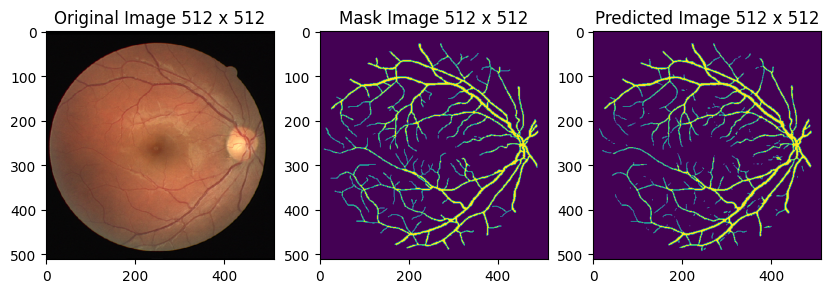

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])
Mask Shape: torch.Size([512, 512]), Mask dtype: torch.int64
Mask Unique: tensor([0, 1])


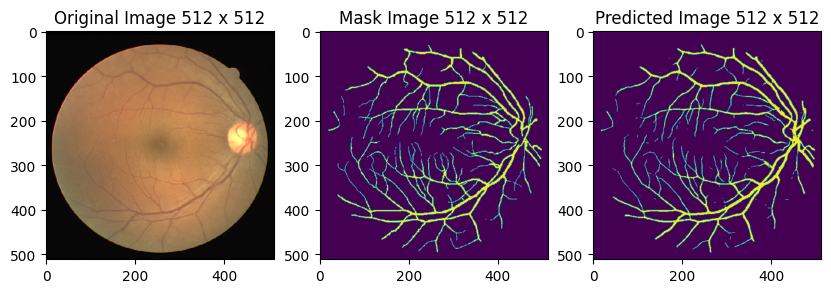

In [ ]:
imgs, masks = next(iter(val_loader))
model.eval()
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    final_output, vgg_output, resnext_output, eff_output = model(imgs)  
    predclass = torch.argmax(final_output, dim=1)
    
    Y = predclass.sum().item()
    X = masks.sum().item()
    
    predclass[predclass == 0] = 2
    
    XintY = (predclass == masks).type(torch.float).sum().item()
    
    print("On Validation Set:", "2*XintY:", 2*XintY, "X:", X, "Y:", Y, "X+Y:", X+Y)
    
    dice_coef = round((2*XintY)/(X+Y), 2)

print("Validation Dice Coef:", dice_coef)
predclass[predclass == 2] = 0

batch_size = imgs.size(0)
for i in range(batch_size):
    plotres(imgs[i], predclass[i], masks[i])

In [ ]:
def continue_training(model, train_loader, val_loader, device, num_epochs=40):
    scaler = torch.cuda.amp.GradScaler()
    
    vgg_params = list(model.vgg_encoder.parameters()) + \
                 list(model.vgg_center.parameters()) + \
                 list(model.vgg_decoder.parameters())
    
    resnext_params = list(model.resnext_encoder.parameters()) + \
                     list(model.resnext_center.parameters()) + \
                     list(model.resnext_decoder.parameters())
    
    efficient_params = list(model.efficient_encoder.parameters()) + \
                      list(model.efficient_center.parameters()) + \
                      list(model.efficient_decoder.parameters())
    
    fusion_params = list(model.fusion.parameters()) + \
                   list(model.fusion_attention.parameters()) + \
                   [model.fusion_weights] + \
                   [model.fusion_temperature]

    optimizer = torch.optim.Adam([
        {'params': vgg_params, 'lr': 0.00005},
        {'params': resnext_params, 'lr': 0.000025},
        {'params': efficient_params, 'lr': 0.000025},
        {'params': fusion_params, 'lr': 0.0001}
    ], weight_decay=1e-4)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2
    )
    
    dice_loss = DiceLoss()
    focal_loss = FocalLoss()
    ce_loss = nn.CrossEntropyLoss()
    
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        track_loss = 0
        XintY = 0
        X = 0
        Y = 0
        
        for i, (imgs, masks) in enumerate(train_loader):
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            with torch.cuda.amp.autocast():
                final_output, vgg_output, resnext_output, efficient_output = model(imgs)
                
                vgg_loss = dice_loss(vgg_output, masks)
                resnext_loss = focal_loss(resnext_output, masks)
                efficient_loss = focal_loss(efficient_output, masks)
                final_loss = ce_loss(final_output, masks)
                
                total_loss = (0.25 * vgg_loss + 
                            0.25 * resnext_loss + 
                            0.25 * efficient_loss + 
                            0.25 * final_loss)
            
            optimizer.zero_grad()
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            track_loss += total_loss.item()
            
            predclass = torch.argmax(final_output, dim=1)
            Y += predclass.sum().item()
            X += masks.sum().item()
            
            predclass[predclass == 0] = 2
            XintY += (predclass == masks).type(torch.float).sum().item()
            
            if i % 5 == 0:
                running_loss = round(track_loss/(i+1), 4)
                running_dice_coef = round((2*XintY)/(X+Y), 4)
                weights = F.softmax(model.fusion_weights / model.fusion_temperature, dim=0)
                print(f"Continued Training - Epoch {epoch+1}, Batch {i+1}/{len(train_loader)}, "
                      f"Loss: {running_loss}, Dice: {running_dice_coef}")
                print(f"Fusion Weights: VGG={weights[0]:.3f}, ResNext={weights[1]:.3f}, "
                      f"EfficientNet={weights[2]:.3f}")
        
        scheduler.step()
        
        model.eval()
        val_track_loss = 0
        val_XintY = 0
        val_X = 0
        val_Y = 0
        
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)
                
                with torch.cuda.amp.autocast():
                    final_output, _, _, _ = model(imgs)
                    loss = ce_loss(final_output, masks)
                
                val_track_loss += loss.item()
                
                predclass = torch.argmax(final_output, dim=1)
                val_Y += predclass.sum().item()
                val_X += masks.sum().item()
                
                predclass[predclass == 0] = 2
                val_XintY += (predclass == masks).type(torch.float).sum().item()
            
            val_dice_coef = round((2*val_XintY)/(val_X+val_Y), 4)
            val_loss = val_track_loss/len(val_loader)
            
            if val_dice_coef > best_val_dice:
                best_val_dice = val_dice_coef
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict(),  
                    'best_val_dice': best_val_dice,
                    'fusion_weights': model.fusion_weights.data,
                    'fusion_temperature': model.fusion_temperature.data
                }, 'best_continued_model.pth')
            
            weights = F.softmax(model.fusion_weights / model.fusion_temperature, dim=0)
            print(f"\nValidation - Epoch {epoch+1}, Loss: {val_loss:.4f}, "
                  f"Dice: {val_dice_coef}, Best Dice: {best_val_dice:.4f}")
            print(f"Final Fusion Weights: VGG={weights[0]:.3f}, ResNext={weights[1]:.3f}, "
                  f"EfficientNet={weights[2]:.3f}")
            print("-" * 80)

train_dataset = TrainDataset("/kaggle/input/sai-vessel-segmentation2/all/train/", "yes")
batch_size = 2


train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

continue_training(model, train_dataloader, val_dataloader, device, num_epochs=50)

<ipython-input-25-abc34ba43011>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-25-abc34ba43011>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Continued Training - Epoch 1, Batch 1/6, Loss: 0.0661, Dice: 0.8391
Fusion Weights: VGG=0.332, ResNext=0.365, EfficientNet=0.303
Continued Training - Epoch 1, Batch 6/6, Loss: 0.0579, Dice: 0.8448
Fusion Weights: VGG=0.332, ResNext=0.365, EfficientNet=0.303


<ipython-input-25-abc34ba43011>:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Validation - Epoch 1, Loss: 0.0631, Dice: 0.8413, Best Dice: 0.8413
Final Fusion Weights: VGG=0.332, ResNext=0.365, EfficientNet=0.303
--------------------------------------------------------------------------------
Continued Training - Epoch 2, Batch 1/6, Loss: 0.053, Dice: 0.8526
Fusion Weights: VGG=0.333, ResNext=0.365, EfficientNet=0.303
Continued Training - Epoch 2, Batch 6/6, Loss: 0.0621, Dice: 0.8351
Fusion Weights: VGG=0.333, ResNext=0.365, EfficientNet=0.303

Validation - Epoch 2, Loss: 0.0583, Dice: 0.8577, Best Dice: 0.8577
Final Fusion Weights: VGG=0.333, ResNext=0.365, EfficientNet=0.303
--------------------------------------------------------------------------------
Continued Training - Epoch 3, Batch 1/6, Loss: 0.0513, Dice: 0.852
Fusion Weights: VGG=0.333, ResNext=0.364, EfficientNet=0.303
Continued Training - Epoch 3, Batch 6/6, Loss: 0.0562, Dice: 0.8328
Fusion Weights: VGG=0.333, ResNext=0.364, EfficientNet=0.303

Validation - Epoch 3, Loss: 0.0611, Dice: 0.8527, B

In [26]:
class TestDataset(Dataset):
    def __init__(self,path):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=len(self.filepaths)
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        idx=idx+1
        if idx <= 9:
            path=self.path + "0" + str(idx) + "_test.tif"
        else:
            path=self.path + str(idx) + "_test.tif"
        
        img=reshape_to_512(path)
        img=self.transform(img)
        
        return img

In [27]:
torch.cuda.empty_cache()

In [28]:
test_dataset=TestDataset("/kaggle/input/sai-vessel-segmentation2/all/test/")

batch_size=2
test_dataloader=DataLoader(dataset=test_dataset,batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


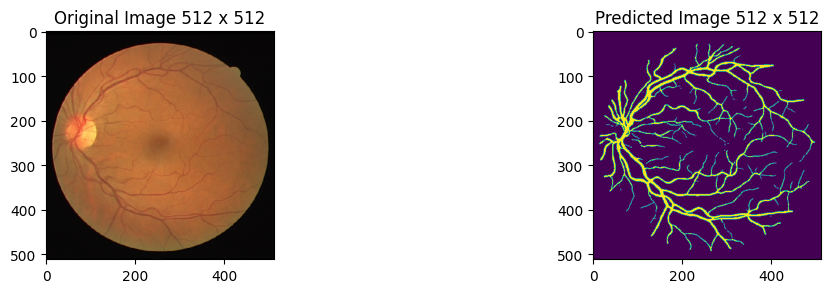

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


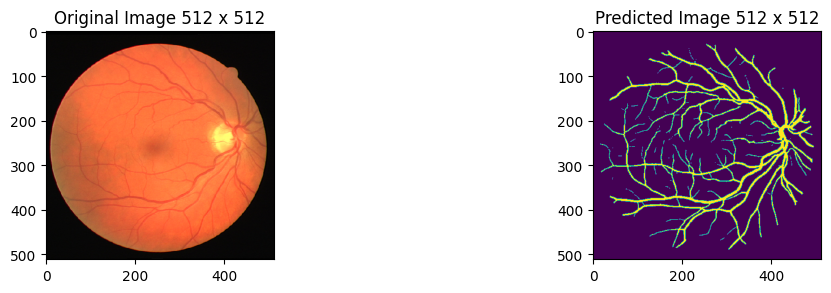

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


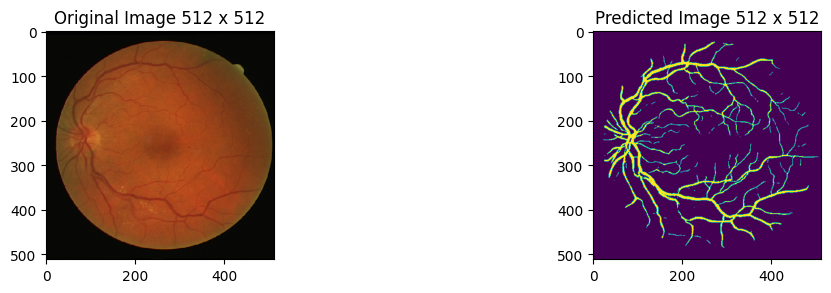

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


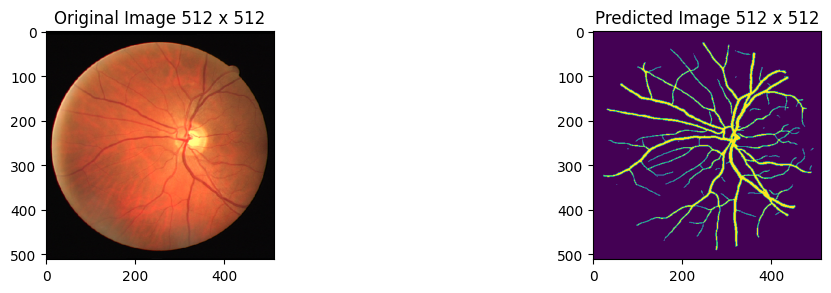

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


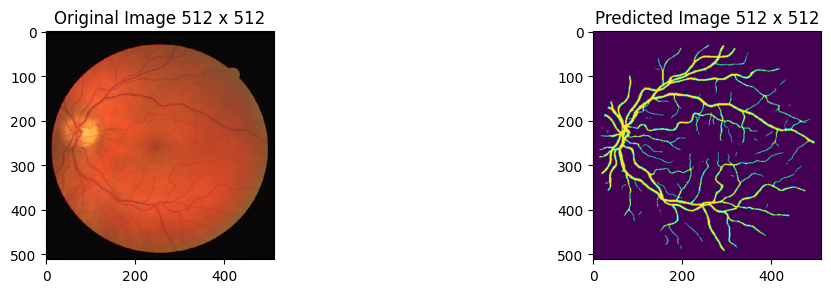

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


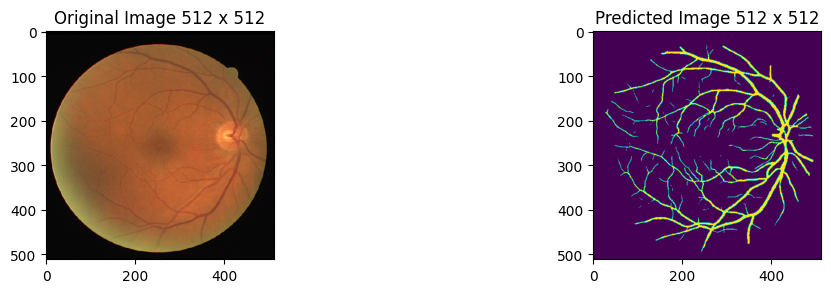

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


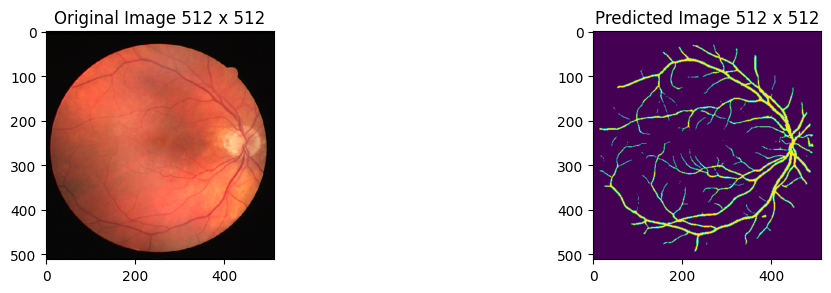

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


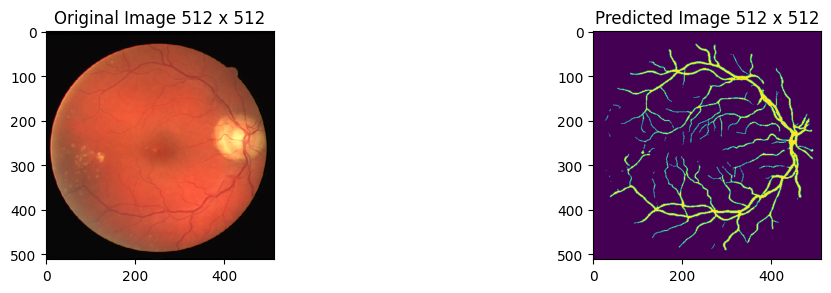

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


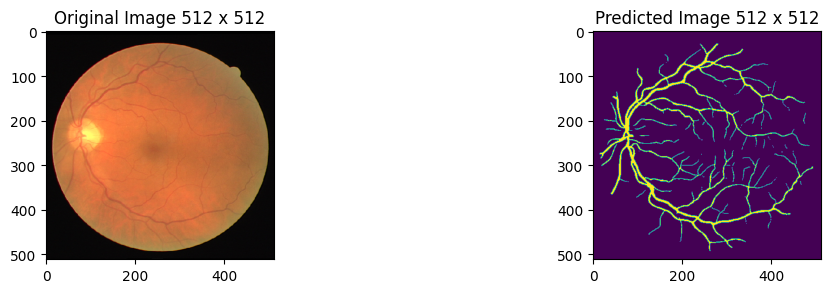

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


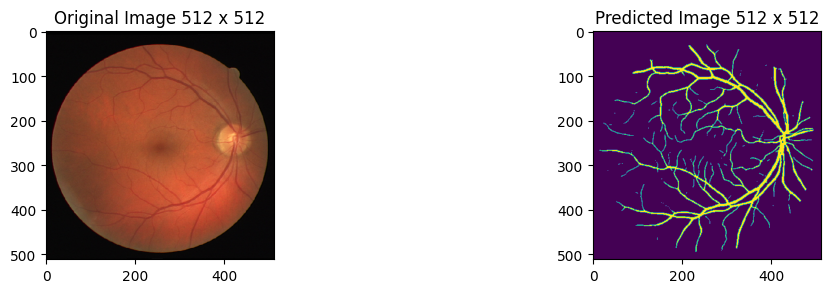

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


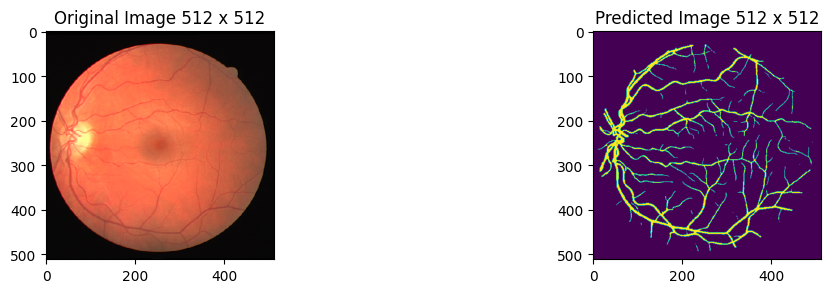

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


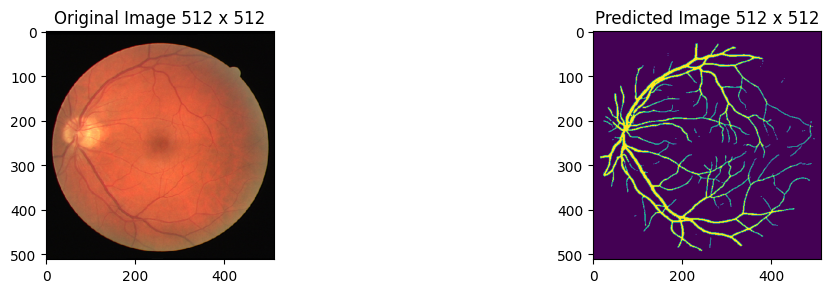

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


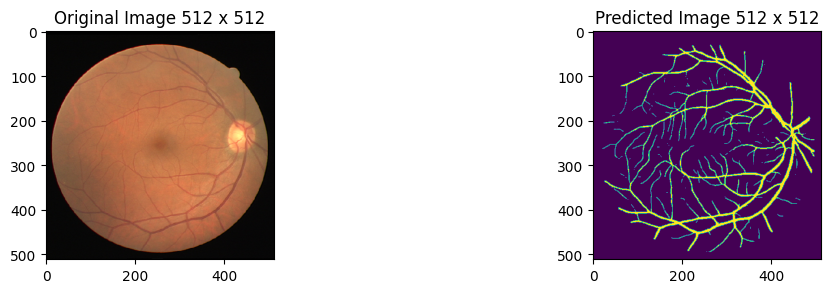

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


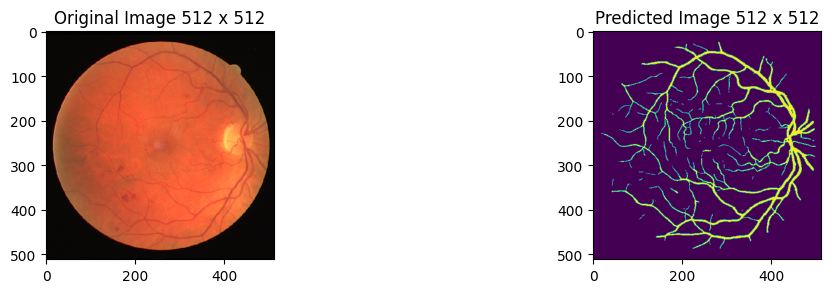

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


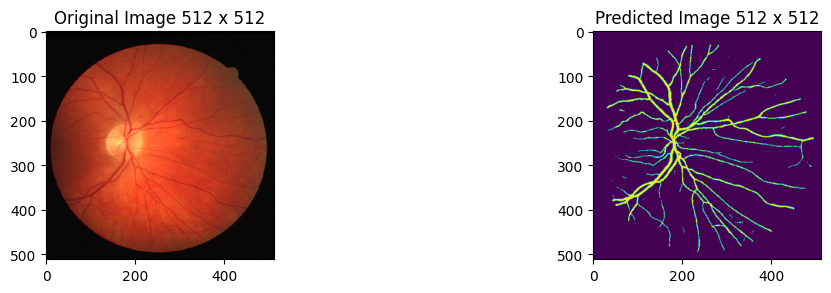

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


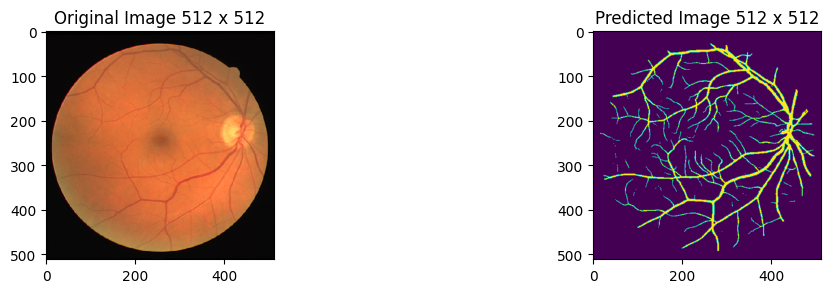

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


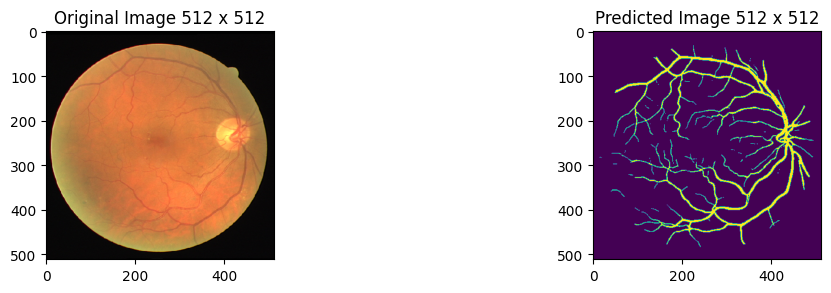

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


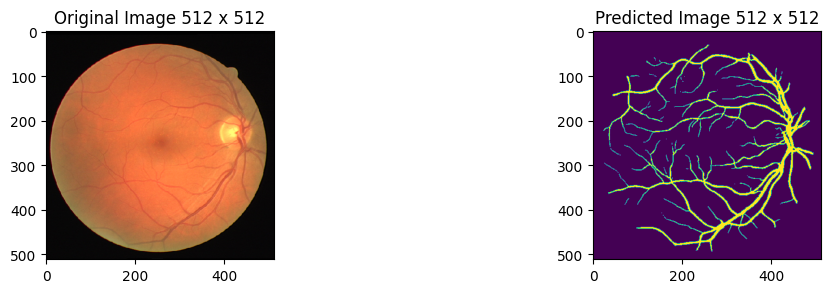

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


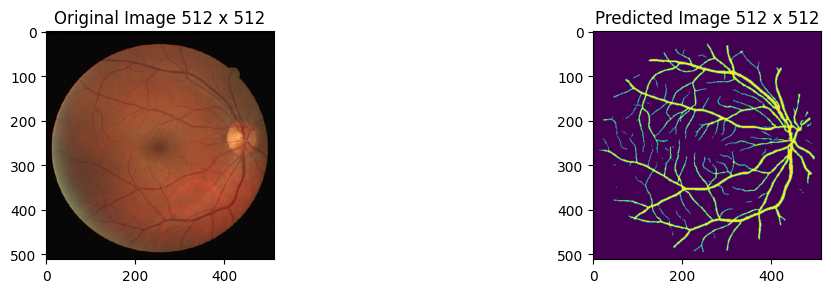

Image Shape: torch.Size([3, 512, 512]), Pred Shape: torch.Size([512, 512]), Image dtype: torch.float32, Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


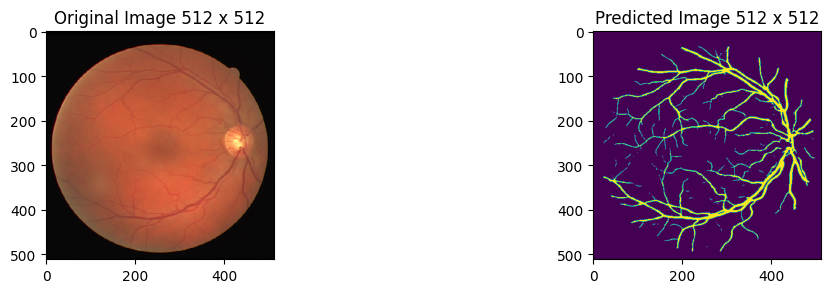

Id                                          Predicted
0    0  15082 2 15109 2 15593 3 15621 2 15653 2 16105 ...
1    1  15103 2 15615 4 16128 5 16147 1 16641 6 16658 ...
2    2  12560 3 13067 8 13578 8 14089 7 14117 2 14599 ...
3    3  13048 1 13559 4 14071 5 14583 5 15096 5 15608 ...
4    4  16132 1 16642 4 16676 3 17153 4 17187 5 17663 ...
5    5  16640 1 17152 1 17188 3 17664 1 17700 5 18116 ...
6    6  16097 2 16143 2 16609 11 16655 2 17122 11 1716...
7    7  15079 3 15591 4 16104 4 16146 3 16617 4 16657 ...
8    8  14614 4 15089 2 15125 5 15602 2 15636 6 16115 ...
9    9  15616 1 16128 1 16600 4 16640 2 17111 5 17152 ...
10  10  15612 3 16090 8 16124 4 16601 10 16636 4 17108...
11  11  14568 4 15079 5 15128 3 15591 5 15640 3 16103 ...
12  12  16136 2 16158 1 16608 2 16648 3 16669 2 17119 ...
13  13  12571 1 13082 3 13594 4 14106 4 14562 1 14619 ...
14  14  15624 2 16094 2 16136 2 16154 2 16606 3 16647 ...
15  15  14600 3 15113 3 15625 5 16138 6 16172 1 16651 ...
16  16  16610 1 17122 1 17634 1 18146 1 18658 1 19170 ...
17  17  16129 5 16641 4 17152 4 17663 4 18174 4 18684 ...
18  18  15105 2 15617 3 16129 4 16642 3 16685 3 17154 ...
19  19  17646 1 18158 4 18224 3 18632 3 18672 5 18735 ...

In [ ]:
def eval_one_epoch(dataloader, model):
    model.eval()
    outputs = []
    for i, imgs in enumerate(dataloader):
        imgs = imgs.to(device)
        with torch.no_grad():
            final_output, _, _, _ = model(imgs)
            
            for i in range(final_output.shape[0]):
                pred = final_output[i,:,:,:]
                pred = torch.argmax(pred, dim=0).cpu()
                
                plotres(imgs[i], pred)
                
                predf = pred.flatten()
                pixelidx = np.where(predf==1)[0]+1
                
                run_lengths = []
                prev = None  
                
                for pxid in pixelidx:
                    if len(run_lengths) == 0:
                        run_lengths.extend((pxid,1))
                    elif pxid > prev+1:
                        run_lengths.extend((pxid,1))
                    else:
                        run_lengths[-1] += 1
                    prev = pxid
                
                output = ' '.join([str(r) for r in run_lengths])
                outputs.append(output)
    return outputs

outputs = eval_one_epoch(test_dataloader, model)
df = pd.DataFrame(columns=['Id','Predicted'])   
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv("submission.csv", index=None)
df